In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from ipywidgets import widgets, interact, interactive, fixed, interact_manual

from IPython.display import display
import string
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
possible_answers = None
probabilities = None
alphabet = list(string.ascii_uppercase)
max_categories = len(alphabet)
dist = None 

In [3]:
categories_slider = widgets.IntSlider(min=1, max=max_categories)

In [4]:
def plot_dist(x_axis, y_axis):
    plt.clf()
    plt.ylabel('%')
    plt.xlabel('Category')
    dist = sns.barplot(x=x_axis, y=y_axis, palette='pastel')

In [5]:
def update_categories(change):
    possible_answers = alphabet[0:categories_slider.value]
    probabilities = np.repeat(1./len(possible_answers), len(possible_answers)).tolist()
    plot_dist(x_axis=pd.Series(possible_answers), y_axis=pd.Series(probabilities))

In [6]:
categories_slider.observe(update_categories)
categories_slider.on_displayed(update_categories)

IntSlider(value=1, max=26, min=1)

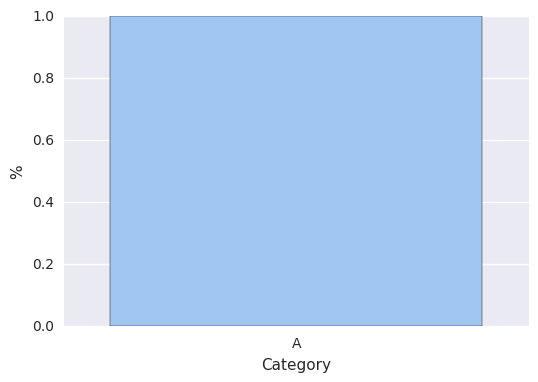

In [7]:
display(categories_slider)